# Testing your causal graph

## Purpose

## Set notebook parameters

In [1]:
# Declare paths to data
DATA_PATH =\
    '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

# Note the columns of interest for this notebook
MODE_ID_COLUMN = 'mode_id'
OBS_ID_COLUMN = 'observation_id'

TIME_COLUMN = 'total_travel_time'
COST_COLUMN = 'total_travel_cost'
DISTANCE_COLUMN = 'total_travel_distance'
LICENSE_COLUMN = 'num_licensed_drivers'
NUM_AUTOS_COLUMN = 'num_cars'

UTILITY_COLUMNS =\
    [TIME_COLUMN,
     COST_COLUMN,
     DISTANCE_COLUMN,
     LICENSE_COLUMN,
     NUM_AUTOS_COLUMN]

# Note the travel mode of intersest for this notebook
DRIVE_ALONE_ID = 1

# Note the number of permutations to be used when
# testing the causal graphs
NUM_PERMUTATIONS = 100

# Choose a color to represent reference /
# permutation-based test statistics
PERMUTED_COLOR = '#a6bddb'

## Import needed libraries

In [2]:
# Built-in modules
import sys

# Third party modules
import pandas as pd

# Local modules
sys.path.insert(0, '../../')
import src.viz.sim_cdf as sim_cdf
import src.testing.observable_independence as oi
import src.testing.latent_independence as li

from src.graphs.drive_alone_utility import DRIVE_ALONE_UTILITY
from src.utils import sample_from_factor_model

## Load and describe needed data

In [3]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

# Look at the data being used in this notebook
print(df.loc[df[MODE_ID_COLUMN] == DRIVE_ALONE_ID,
             UTILITY_COLUMNS + [OBS_ID_COLUMN]]
        .head(5)
        .T)

# Create a dataframe with the variables posited
# to make up the drive-alone utility
drive_alone_df =\
    df.loc[df[MODE_ID_COLUMN] == DRIVE_ALONE_ID,
           UTILITY_COLUMNS]

                           0        8        16       24       32
total_travel_time      54.010  39.7800  22.2200  22.3000  47.9500
total_travel_cost       5.714   4.4519   1.6817   1.6817   5.9782
total_travel_distance  30.920  24.0900   9.1000   9.1000  32.3500
num_licensed_drivers    2.000   2.0000   2.0000   2.0000   2.0000
num_cars                2.000   2.0000   2.0000   2.0000   2.0000
observation_id          1.000   2.0000   3.0000   4.0000   5.0000


## Show the posited causal graph

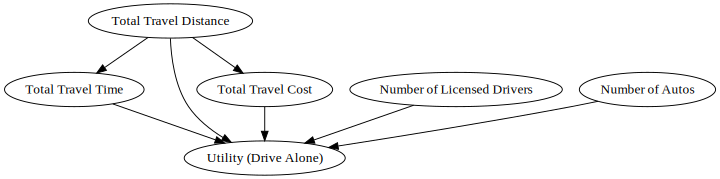

In [4]:
# Draw the causal model being tested
causal_graph = DRIVE_ALONE_UTILITY.draw()
causal_graph.graph_attr.update(size="10,6")
causal_graph

## Marginal independence tests

### Main idea
The marginal independence tests demonstrated in this notebook will visually test the following implication<br>
$
\begin{aligned}
P \left( X_1 \mid X_2 \right) &= P \left( X_1 \right) \\
\int x_1 P \left( X_1 \mid X_2 \right) \partial{x_1}  &= \int x_1 P \left( X_1 \right) \partial{x_1} \\
E \left[ X_1 \mid X_2 \right] &= E \left[ X_1 \right]
\end{aligned}
$

In other words, if $X_1$ is marginally independent of $X_2$, then the expectation of $X_1$ conditional on $X_2$ is equal to the marginal expectation of $X_1$. Marginal independence implies mean independence. This means that shuffling / permuting the $X_2$ columns should make no difference to predicting $X_1$, once one predicts $\bar{X_1}$.

The test demonstrated below works by estimating a linear regression to predict $E \left[ X_1 \mid X_2 \right]$. The $r^2$ from these regressions is computed using the observed value of $X_2$, and it is also computed using the permuted values of $X_2$ (which are independent of $X_1$ by construction).

If $X_1$ is marginally independent of $X_2$, then the $r^2$ using the observed values of $X_2$ should be similar to the distribution of $r^2$ using the permuted values of $X_2$.

For this test, we'll use the following marginal independence assumption implied by the causal graph above:<br>
$
P \left( \textrm{Number of Automobiles} \mid \textrm{Number of licensed drivers} \right) = P \left( \textrm{Number of Automobiles} \right)
$

100%|██████████| 100/100 [00:00<00:00, 1020.77it/s]

The p-value of the permutation independence test is 0.00.


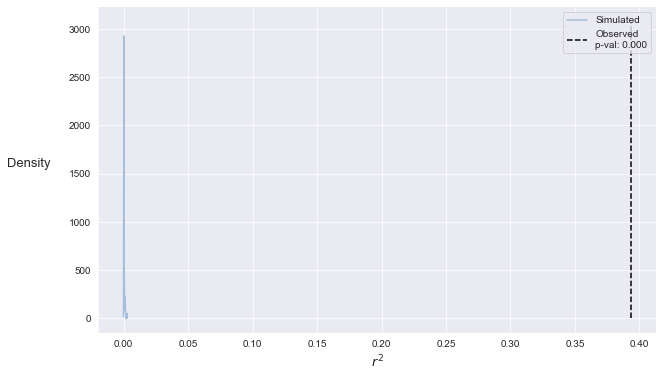

0.0

In [5]:
license_array = drive_alone_df[LICENSE_COLUMN].values
num_cars_array = drive_alone_df[NUM_AUTOS_COLUMN].values

oi.visual_permutation_test(
    license_array,
    num_cars_array,
    z_array=None,
    seed=1038,
    num_permutations=NUM_PERMUTATIONS,
    permutation_color=PERMUTED_COLOR)

## Conditional independence tests

### Main idea

100%|██████████| 100/100 [00:00<00:00, 864.60it/s]


The p-value of the permutation independence test is 0.00.


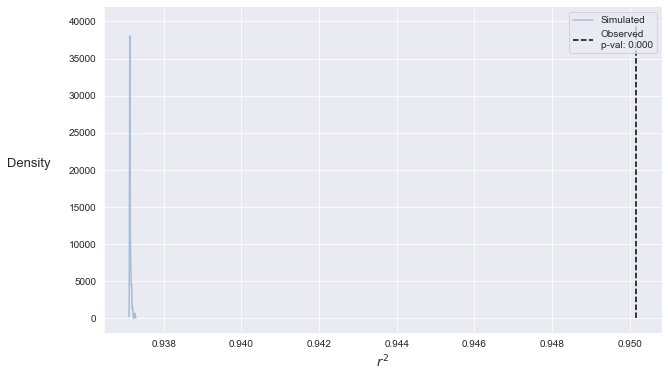

0.0

In [6]:
time_array = drive_alone_df[TIME_COLUMN].values
cost_array = drive_alone_df[COST_COLUMN].values
distance_array = drive_alone_df[DISTANCE_COLUMN].values

oi.visual_permutation_test(
    time_array,
    cost_array,
    z_array=distance_array,
    num_permutations=NUM_PERMUTATIONS,
    permutation_color=PERMUTED_COLOR)

### Caveats and pitfalls

## Latent conditional independence tests


### Show the posited causal graph

### Main idea

### Caveats and pitfalls

## Summary